# Topics in English Quran

In [1]:
import glob
from collections import defaultdict
import pdb

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from gensim import corpora, models
# from gensim.utils import lemmatize  # not working with PY3.7 due to Pattern package
from wordcloud import WordCloud
import spacy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 500)

# import nltk
# nltk.download()

## Pre-processing

In [2]:
def parse_docs(docs, is_stop=True, additional_stops=None):
    # removing whitespaces, punctuations, stopwords, and stemming words
    # https://gist.github.com/sangheestyle/8691435
    intermediates = []
    processed = []
    stem_map = defaultdict(set)
    
    tokenizer = RegexpTokenizer(r'\w+')
    stop = stopwords.words('english')
    stemmer = PorterStemmer()
    # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except: 
        nlp = en_core_web_sm.load(disable=['parser', 'ner'])
    
    # Remove udf stop words
    if additional_stops is not None:
        stop = stop + additional_stops 
    
    for document in docs:
        intermediate = tokenizer.tokenize(document)    
#         POS tagging
#         ntlk.pos_tag()
        if is_stop:
            intermediate = [i for i in intermediate if i not in stop]        

        # Lemmatization or stemming
        final = []
        # Lemmatization
        # Parse the sentence using the loaded 'en' model object `nlp`
        # Extract the lemma for each token and join
        nlp_parsed = nlp(' '.join(intermediate))
        for i in nlp_parsed:                        
            stem_map[i.lemma_].add(i.text)
            final.append(i.lemma_)
        
        # Or do stemming instead
#         for i in intermediate:
#             stemmed = stemmer.stem(i)
#             final.append(stemmed)
#             stem_map[stemmed].add(i)
    
        intermediates.append(intermediate)
        processed.append(final)
    
    return intermediates, processed, stem_map

def word_cloud(input_text):
    # Read the whole text.
    text = ' '.join(input_text)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=60).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [3]:
sura_medina = [2, 3, 4, 5, 8, 9, 22, 24, 33, 47, 48, 49, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 98, 110]
sura_mecca_first = [96, 74, 111, 106, 108, 104, 107, 102, 105, 92,
90, 94, 93, 97, 86, 91, 80, 68, 87, 95,
103, 85, 73, 101, 99, 82, 81, 53, 84, 100,
79, 77, 78, 88, 89, 75, 83, 69, 51, 52,
56, 70, 55, 112, 109, 113, 114, 1]
sura_mecca_second = [54, 37, 71, 76, 44, 50, 20, 26, 15, 19,
38, 36, 43, 72, 67, 23, 21, 25, 17, 27, 18]
sura_mecca_third = [32, 41, 45, 16, 30, 11, 14, 12, 40, 28,
39, 29, 31, 42, 10, 34, 35, 7, 46, 6, 13]
sura_ind = [sura_mecca_first, sura_mecca_second, sura_mecca_third, sura_medina]

Basmala = 'in the name of allah, the gracious, the merciful.'

### Read in and decode

In [4]:
### Downloaded at http://www.clearquran.com/

data_folder = '../data/quran-verse-by-verse-text/'

documents = [] # chapters->chapters
for chapter in range(1, 115):
    files = sorted(glob.glob(data_folder + str(chapter).zfill(3) + '*'))
    # Remove non ascii and change to lower case; not necessary with RegexpTokenizer(r'\w+')
    verses = []
    for f in files:
        with open(f, 'rb') as hf:
            text = hf.read()
            verses.append(text.decode('utf-8').encode('ascii', errors='ignore').lower().decode('utf-8'))
    documents.append(verses)

### [optional] Separate by time

In [5]:
# chapters->verses, remove Basmala
suras = range(1, 115) #sura_ind[-1]
seg_docs = [documents[ii - 1] for ii in suras]

docs = []
i_surah = []
i_verse = []
for i, surah in enumerate(seg_docs):
    for j, verse in enumerate(surah):
        docs.append(verse)
        i_surah.append(i + 1)
        i_verse.append(j + 1)

In [6]:
is_remove_basm = True
if is_remove_basm:
    for i, j in enumerate(i_verse):
        if j == 1:
            del i_verse[i]
            del i_surah[i]
            del docs[i]

In [7]:
df0 = pd.DataFrame({'text': docs, 'surah': i_surah, 'verse': i_verse})

### Parsing 

In [8]:
additional_stops = None #['god', 'lord']
tokens, processed, stem_map = parse_docs(docs, is_stop=True, additional_stops=additional_stops)

## Some EDA

### Word freq

In [9]:
df = pd.Series([jj for ii in processed for jj in ii])

df.value_counts()[:4]

allah     2417
say       1587
lord       965
people     683
dtype: int64

In [10]:
# check some verses 
# count = 0
# for ii, jj in enumerate(tokens):    
#     if 'day' in jj:
#         count += 1
#         print(ii, docs[ii])
#         if count > 2:
#             break

### get ngram

In [11]:
num_grams = 3
input_corpus = processed
ngrams_by_verse = [list(ngrams(token, num_grams)) for token in input_corpus]

In [12]:
all_ngrams = []
ind_surah = []
ind_verse = []
for i, j in enumerate(ngrams_by_verse):
    for g in j:
        ind_surah.append(i_surah[i])
        ind_verse.append(i_verse[i])
        all_ngrams.append(g)

In [13]:
dfng = pd.DataFrame({'value': all_ngrams, 'surah': ind_surah, 'verse': ind_verse})

In [14]:
dfng_j = pd.merge(dfng, df0, on=['surah', 'verse'])

In [15]:
dfng_j['value'].value_counts()[:10]

(allah, forgiving, merciful)    35
(lord, marvel, deny)            32
(create, heavens, earth)        31
(beneath, river, flow)          30
(garden, beneath, river)        23
(allah, last, day)              23
(believe, allah, last)          20
(believe, good, deed)           19
(give, good, news)              16
(jesus, son, mary)              15
Name: value, dtype: int64

In [16]:
dfng_j[dfng_j['value'] == dfng_j['value'].value_counts().index[0]][:4]

,value,surah,verse,text
1850,"(allah, forgiving, merciful)",2,174,"he has forbidden you carrion, and blood, and the flesh of swine, and what was dedicated to other than allah. but if anyone is compelled, without desiring or exceeding, he commits no sin. allah is forgiving and merciful."
1979,"(allah, forgiving, merciful)",2,183,"should someone suspect bias or injustice on the part of a testator, and then reconciles between them, he commits no sin. allah is forgiving and merciful."
2141,"(allah, forgiving, merciful)",2,193,"but if they cease, then allah is forgiving and merciful."
2267,"(allah, forgiving, merciful)",2,200,"then disperse from where the people disperse, and ask allah for forgiveness. allah is most forgiving, most merciful."


## Embedding and similarity 

In [21]:
import gensim.models as w2v
model = w2v.Word2Vec(sentences=processed, size=100, window=7, min_count=15, sg=0, alpha=0.22, workers=8)
# model.save('./tokens_CBOW.model')

In [22]:
wv = model.wv

In [23]:
wv.most_similar("jesu", topn=10)

[('mari', 0.691387414932251),
 ('isaac', 0.6848706007003784),
 ('stori', 0.6371889710426331),
 ('teach', 0.6221617460250854),
 ('gave', 0.6040931344032288),
 ('confirm', 0.5926929712295532),
 ('solomon', 0.5879420042037964),
 ('son', 0.5582972764968872),
 ('daughter', 0.5577701330184937),
 ('abraham', 0.5494280457496643)]

In [24]:
from sklearn.decomposition import PCA
words = df.value_counts()[:200].index.values
X = np.array([wv[w] for w in words])

pca = PCA(n_components=2)
result = pca.fit_transform(X)


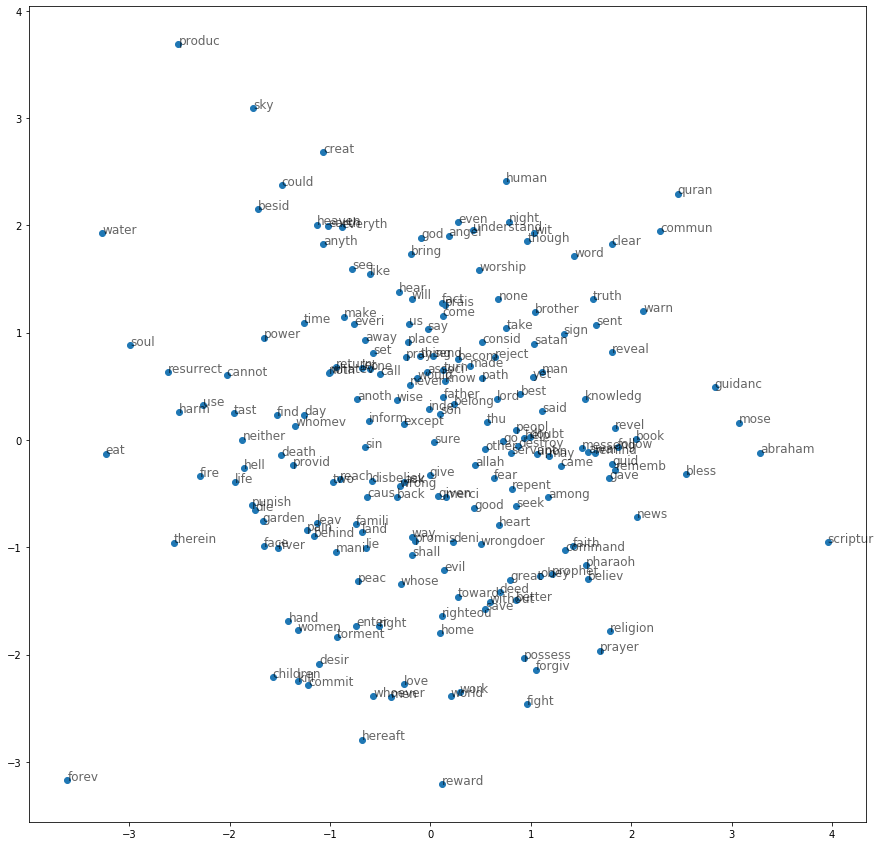

In [26]:
# create a scatter plot of the projection
f, a = plt.subplots(figsize=(15, 15))
a.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    a.annotate(word, xy=(result[i, 0], result[i, 1]), alpha=0.6, fontsize=12)
plt.show()

## Topics

### Parse by surah

In [19]:
df0['processed'] = processed
processed_by_surah = df0.groupby('surah')['processed'].apply(sum).values.tolist()

# remove '-PRON-'
processed_by_surah = [list(filter(lambda a: a != '-PRON-', i)) for i in processed_by_surah]

### Making dictionary and corpus

In [21]:
# making dictionary and corpus
dictionary = corpora.Dictionary(processed_by_surah)
corpus = [dictionary.doc2bow(text) for text in processed_by_surah]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
# Save
#dictionary.save('/tmp/dict.dict')
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

### TFIDF

In [22]:
item_document_fre = dictionary.dfs
for k in dictionary.keys()[:4]:
    print(k, dictionary[k], item_document_fre[k])

0 allah 82
1 anger 4
2 bless 29
3 call 53


In [24]:
# Compare bow and tiidf
i = 0
print(processed_by_surah[i], '\n',
      [dictionary[k[0]] for k in corpus[i]], '\n',
      corpus[i], '\n', 
      corpus_tfidf[i])

['praise', 'allah', 'lord', 'world', 'gracious', 'merciful', 'master', 'day', 'judgment', 'worship', 'upon', 'call', 'help', 'guide', 'straight', 'path', 'path', 'bless', 'anger', 'misguide'] 
 ['allah', 'anger', 'bless', 'call', 'day', 'gracious', 'guide', 'help', 'judgment', 'lord', 'master', 'merciful', 'misguide', 'path', 'praise', 'straight', 'upon', 'world', 'worship'] 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)] 
 [(0, 0.04845352024773868), (1, 0.492640036044582), (2, 0.2013121025870043), (3, 0.11263493315072866), (4, 0.043169325280030334), (5, 0.2982613828990869), (6, 0.10193487428861422), (7, 0.18683541317873928), (8, 0.24193818317734606), (9, 0.028368594012498187), (10, 0.2982613828990869), (11, 0.13669842963590823), (12, 0.43301195707001744), (13, 0.2936891720131065), (14, 0.14684458600655326), (15, 0.2231388877027208), (16, 0.07816374556897575), (17, 0.1695

### LDA

In [65]:
# LDA modeling
NUM_TOPICS = 20
NUM_WORDS = 10

corpus_input = corpus_tfidf

lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)
corpus_lda = lda[corpus_input] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
topics = lda.print_topics(num_topics=-1, num_words=NUM_WORDS)

In [66]:
print('Perplexity: ', lda.log_perplexity(corpus_input))
coherence_model_lda = models.CoherenceModel(
    model=lda, texts=processed_by_surah, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -16.362223436440342

Coherence Score:  0.43062844131068817


### Hyperparameter optimization

In [67]:
num_topics_list = range(5, 40, 4)
lda_models = []
coherence_scores = []
for NUM_TOPICS in num_topics_list:
    lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)
    coherence_model_lda = models.CoherenceModel(
        model=lda, texts=processed_by_surah, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    lda_models.append(lda)
    coherence_scores.append(coherence_lda)

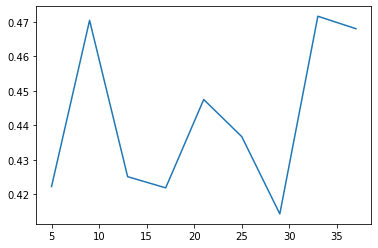

In [68]:
plt.plot(num_topics_list, coherence_scores)

### Results

In [55]:
# Get score for individual verse
i = 107
print(processed_by_surah[i])
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print('Top 3 topics of this doc: \n', sorted_rel[:3])
print('First topic: \n', topics[sorted_rel[0][0]])
print('2nd topic: \n', topics[sorted_rel[1][0]])

['give', 'plenty', 'pray', 'lord', 'sacrifice', 'hate', 'loser']
Top 3 topics of this doc: 
 [(8, 0.67453676), (0, 0.039695486), (1, 0.015875984)]
First topic: 
 (8, '0.003*"encourage" + 0.002*"plenty" + 0.002*"sacrifice" + 0.002*"recommend" + 0.002*"hate" + 0.002*"considered" + 0.002*"assistance" + 0.002*"feeding" + 0.001*"loss" + 0.001*"appearance"')
2nd topic: 
 (0, '0.010*"allah" + 0.007*"say" + 0.004*"people" + 0.003*"believe" + 0.003*"lord" + 0.003*"messenger" + 0.003*"one" + 0.003*"day" + 0.003*"come" + 0.003*"would"')


In [43]:
len()

114

In [69]:
ind_max_topic = [max(i, key=lambda x: x[1])[0] for i in corpus_lda]

In [70]:
ind_max_topic

[16,
 16,
 16,
 16,
 0,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 0,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 0,
 16,
 0,
 3,
 16,
 16,
 17,
 3,
 16,
 16,
 13,
 16,
 16,
 16,
 0,
 7,
 8,
 4,
 16,
 10,
 0,
 16,
 0,
 19,
 10,
 16,
 16,
 6,
 12,
 14,
 1,
 11,
 10,
 13,
 8,
 16,
 6,
 8,
 18,
 17,
 1,
 12,
 8,
 15,
 18,
 1,
 18,
 16,
 19,
 19,
 15,
 10,
 12,
 15,
 16,
 13,
 13,
 8,
 10,
 10,
 16,
 4,
 18,
 14,
 10,
 17,
 3,
 0,
 10]

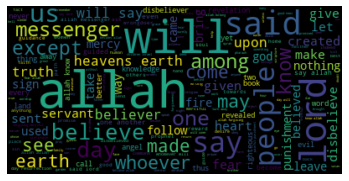

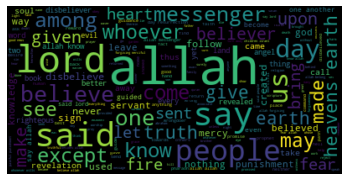

In [33]:
word_cloud(docs)
word_cloud([' '.join(ii) for ii in tokens])

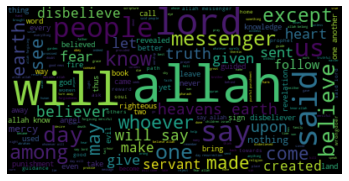

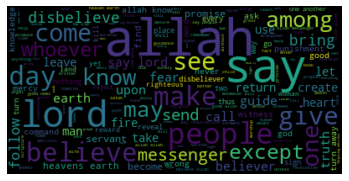

In [36]:
word_cloud(docs)
word_cloud([' '.join(ii) for ii in processed_by_surah])